Review the codes and tell us if 74% accuracy on the test set was reliable

The test set had a ratio of HGG examples equal to about 0.7432432432432432. This would mean that the accuracy of 74% is not reliable. Baseline accuracy is the class size of the biggest class, which is the HGG class. We see that the accruacy is about the same as the biggest class proportion, deeming that the accuracy is not reliable.

In [ ]:
# loading the required libraries
from google.colab import drive
import os
import random
import pickle
import shutil
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# Seeding (to get reproducable results)
def random_seed(seed_value, use_cuda):
    """
    Parameters
    ----------
    seed_value : int
        The desired seed number
    use_cuda : Boolean
        True if GPU seeding is desired, False, otherwise

    Returns
    -------
    None.
    """
    np.random.seed(seed_value) # numpy seed
    torch.manual_seed(seed_value) # torch cpu vars
    random.seed(seed_value) # Python seed
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # torch gpu vars
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

random_seed(0, True)

In [ ]:
drive.mount("/content/drive/")
os.chdir("/content/drive/MyDrive/IMS_Course_2023/Week_4")

Mounted at /content/drive/


In [ ]:
# the needed functions and classes
def load_object(filename):
  # opening a file in read, binary form
  file = open(filename, 'rb')

  ob = pickle.load(file)

  # close the file
  file.close()
  return ob


class BratsDataset(Dataset):
  def __init__(self, ROIs, labels, pIDs, inds, shuffle):
    self.len = len(inds)
    self.ROIs = [ROIs[i] for i in inds]
    self.labels = [labels[i] for i in inds]
    self.pIDs = [pIDs[i] for i in inds]

    if shuffle is True:
      p = np.random.permutation(self.len)
      self.ROIs = [self.ROIs[i] for i in p]
      self.labels = [self.labels[i] for i in p]
      self.pIDs = [self.pIDs[i] for i in p]
    self.ROIs = np.stack(self.ROIs, axis=0)

  def __len__(self):
    return (self.len)

  def __getitem__(self, idx):
    roi = self.ROIs[idx, :, :, :]
    lbl = self.labels[idx]
    pid = self.pIDs[idx]
    sample = {'ROI': roi, 'label': lbl, 'pID': pid}
    return sample

  def positive_ratio(self):
    count = 0
    for lb in self.labels:
      if lb==1:
        count += 1
    return count/len(self)

  def negative_ratio(self):
    return 1-self.positive_ratio()


In [ ]:
ROIs = load_object("./Data/ROIs.p")
labels = load_object("./Data/labels.p")
pIDs = load_object("./Data/pIDs.p")

In [ ]:
print(type(ROIs)) #what is "ROIs"?
print(type(ROIs[0])) #what is the first element is ROIs?
print(ROIs[0].shape) #how big are the ROIs?

<class 'list'>
<class 'numpy.ndarray'>
(103, 161, 69)


In [ ]:
N = len(labels) #Number of patients
inds = [i for i in range(N)]
ind_dev, ind_test, y_dev, y_test = train_test_split(inds, labels, test_size=0.2, random_state=0)

In [ ]:
ind_train, ind_val, y_train, y_val = train_test_split(ind_dev, y_dev, test_size=0.25, random_state=0)

train_dset = BratsDataset(ROIs, labels, pIDs, ind_train, shuffle=True) #we could turn off shuffling because train_test_split shuffles the inds
val_dset = BratsDataset(ROIs, labels, pIDs, ind_val, shuffle=False)
test_dset = BratsDataset(ROIs, labels, pIDs, ind_test, shuffle=False)

In [ ]:
len(train_dset)

221

In [ ]:
torch.cuda.is_available()

True

In [ ]:
class NN3d(nn.Module):
  def __init__(self, in_chans):
    super(NN3d, self).__init__()

    # Convolution 1
    self.cnn1 = nn.Conv3d(in_channels=in_chans,
                          out_channels=8,
                          kernel_size=5,
                          stride=1,
                          padding=0)

    self.bn1 = nn.BatchNorm3d(8)
    self.maxpool1 = nn.MaxPool3d(kernel_size=(2,2,2))
    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(p=0.1)

    # Convolution 2
    self.cnn2 = nn.Conv3d(in_channels=8,
                          out_channels=16,
                          kernel_size=3,
                          stride=1,
                          padding=0)
    self.bn2 = nn.BatchNorm3d(16)
    self.maxpool2 = nn.MaxPool3d(kernel_size=(2,2,2))
    self.relu2 = nn.ReLU()
    self.dropout2 = nn.Dropout(p=0.1)

    # Convolution 3
    self.cnn3 = nn.Conv3d(in_channels=16,
                          out_channels=32,
                          kernel_size=3,
                          stride=1,
                          padding=0)
    self.bn3 = nn.BatchNorm3d(32)
    self.maxpool3 = nn.MaxPool3d(kernel_size=(2,2,2))
    self.relu3 = nn.ReLU()
    self.dropout3 = nn.Dropout(p=0.1)

    # Convolution 4
    self.cnn4 = nn.Conv3d(in_channels=32,
                          out_channels=64,
                          kernel_size=3,
                          stride=1,
                          padding=0)
    self.bn4 = nn.BatchNorm3d(64)
    self.maxpool4 = nn.MaxPool3d(kernel_size=(2,2,2))
    self.relu4 = nn.ReLU()
    self.dropout4 = nn.Dropout(p=0.1)

    # Fully connected Layers
    self.fc1 = nn.Linear(4096, 1024)
    self.fc2 = nn.Linear(1024, 128)
    self.fc3 = nn.Linear(128, 2)

  def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.bn1(out)
        out = self.maxpool1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        # Convolution 2
        out = self.cnn2(out)
        out = self.bn2(out)
        out = self.maxpool2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        # Convolution 3
        out = self.cnn3(out)
        out = self.bn3(out)
        out = self.maxpool3(out)
        out = self.relu3(out)
        out = self.dropout3(out)

        # Convolution 4
        out = self.cnn4(out)
        out = self.bn4(out)
        out = self.maxpool4(out)
        out = self.relu4(out)
        out = self.dropout4(out)

        out = out.view(out.size(0), -1)

        # Linear function
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

In [ ]:
model = NN3d(in_chans=1)

In [ ]:
if torch.cuda.is_available():
    model.cuda()

#Calculate AUC score and define train epoch function

In [ ]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Function to calculate AUC
def calculate_auc(loader, model):
    model.eval()
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for i_batch, data in enumerate(loader):
            if torch.cuda.is_available():
                images = Variable(data['ROI'].float().cuda())
                labels = Variable(data['label'].long().cuda())
            else:
                images = Variable(data['ROI'].float())
                labels = Variable(data['label'].long())
            images = torch.unsqueeze(images, 1)

            outputs = model(images)
            probs = nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    auc = roc_auc_score(all_labels, all_probs)
    return auc

    # Modified training and validation loop to record AUC
def train_epoch(model, optimizer, criterion, dataloader, val_loader, batch_size, num_epochs):
    train_auc_values = []
    val_auc_values = []
    best_val_auc = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss_tr = 0

        for i_batch, sample_batched in enumerate(dataloader):
            tot_loss, _, _ = train_batch(model, optimizer, criterion, sample_batched)
            epoch_loss_tr += tot_loss

        epoch_loss_tr /= (i_batch+1)

        # Calculate AUC on training set
        train_auc = calculate_auc(dataloader, model)
        train_auc_values.append(train_auc)

        print(f"Epoch: {epoch + 1}/{num_epochs} | Avg Train Loss: {epoch_loss_tr:.4f} | Train AUC: {train_auc:.4f}")

        # Calculate AUC on validation set
        val_loss, _, _ = evaluate(val_loader, model, criterion, batch_size)
        val_auc = calculate_auc(val_loader, model)
        val_auc_values.append(val_auc)

        print(f"Validation Loss: {val_loss:.4f} | Validation AUC: {val_auc:.4f}")

        # Save model with the best validation AUC
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            if os.path.exists("./models"):
                shutil.rmtree("./models")
            os.mkdir("./models")
            torch.save(model, './models/best_model.pth')

    # Plot AUC values over epochs
    plt.plot(range(1, num_epochs + 1), train_auc_values, label='Training AUC')
    plt.plot(range(1, num_epochs + 1), val_auc_values, label='Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

    return best_val_auc

## Core Elements

In [ ]:
def evaluate(test_loader, model, criterion, batch_size):
    # Calculate Accuracy
    pr = []  # List of predicted values
    lb = []  # List of target labels
    # Iterate through test dataset
    epoch_loss_ts = 0
    for i_batch, data in enumerate(test_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(data['ROI'].float().cuda())
            labels = Variable(data['label'].long().cuda())
        else:
            images = Variable(data['ROI'].float())
            labels = Variable(data['label'].long())
        images = torch.unsqueeze(images, 1)


        outputs = model(images)
        probs = nn.functional.softmax(outputs, dim=1)
        loss = criterion(probs, labels)
        epoch_loss_ts += loss.item()

        predicted = (probs[:, 1] > 0.5)

        #######################
        #  USE GPU FOR MODEL  #
        #######################
        for item in list(predicted.cpu().detach().numpy()):
            pr.append(item)

        for item in list(labels.cpu().numpy()):
            lb.append(item)

    epoch_loss_ts = epoch_loss_ts / (i_batch+1)
    return epoch_loss_ts, pr, lb


def train_batch(model, optimizer, criterion, sample_batched):
    #######################
    #  USE GPU FOR MODEL  #
    #######################
    tot_loss = 0
    batch_pr = []  # List of predicted values
    batch_lb = []  # List of target labels
    if torch.cuda.is_available():
        images = Variable(sample_batched['ROI'].float().cuda())
        labels = Variable(sample_batched['label'].long().cuda())
    else:
        images = Variable(sample_batched['ROI'].float())
        labels = Variable(sample_batched['label'].long())
    images = torch.unsqueeze(images, 1)


    # Clear gradients w.r.t. parameters
    optimizer.zero_grad()

    # Forward pass to get output/logits
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    #print(predicted)

    # Calculate Loss: softmax --> cross entropy loss
    loss = criterion(outputs, labels)
    tot_loss += loss.item()
    # print(loss.item())

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()


    # print(i_batch)
    for item in list(predicted.cpu().detach().numpy()):
        batch_pr.append(item)
    for item in list(labels.cpu().numpy()):
        batch_lb.append(item)
    return tot_loss, batch_pr, batch_lb

## Loss Function

In [ ]:
if torch.cuda.is_available():
  class_weights = torch.tensor([train_dset.negative_ratio()**-1, train_dset.positive_ratio()**-1]).float().cuda()
else:
  class_weights = torch.tensor([train_dset.negative_ratio()**-1, train_dset.positive_ratio()**-1]).float()
  print(class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)

## Hyperparameters


Hyperparameter Search

Epoch: 1/10 | Avg Train Loss: 0.5439 | Train AUC: 0.5252
Validation Loss: 0.5736 | Validation AUC: 0.6494
Epoch: 2/10 | Avg Train Loss: 0.5156 | Train AUC: 0.5591
Validation Loss: 0.5579 | Validation AUC: 0.6709
Epoch: 3/10 | Avg Train Loss: 0.4790 | Train AUC: 0.6214
Validation Loss: 0.5605 | Validation AUC: 0.6620
Epoch: 4/10 | Avg Train Loss: 0.4987 | Train AUC: 0.6748
Validation Loss: 0.5805 | Validation AUC: 0.6999
Epoch: 5/10 | Avg Train Loss: 0.4506 | Train AUC: 0.7535
Validation Loss: 0.5905 | Validation AUC: 0.6595
Epoch: 6/10 | Avg Train Loss: 0.4301 | Train AUC: 0.6305
Validation Loss: 0.5381 | Validation AUC: 0.6583
Epoch: 7/10 | Avg Train Loss: 0.4499 | Train AUC: 0.7190
Validation Loss: 0.5705 | Validation AUC: 0.7011
Epoch: 8/10 | Avg Train Loss: 0.4247 | Train AUC: 0.7698
Validation Loss: 0.5665 | Validation AUC: 0.6734
Epoch: 9/10 | Avg Train Loss: 0.4210 | Train AUC: 0.8226
Validation Loss: 0.5935 | Validation AUC: 0.6393
Epoch: 10/10 | Avg Train Loss: 0.3925 | Train 

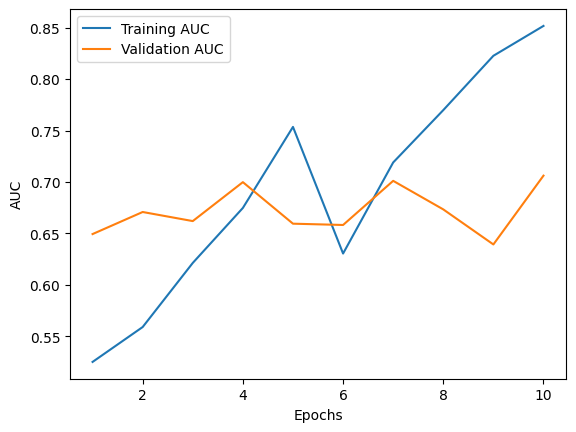

Learning Rate: 5e-05, Batch Size: 1, Validation AUC: 0.7061790668348046
Epoch: 1/10 | Avg Train Loss: 0.7032 | Train AUC: 0.5092
Validation Loss: 0.6935 | Validation AUC: 0.6873
Epoch: 2/10 | Avg Train Loss: 0.6999 | Train AUC: 0.5944
Validation Loss: 0.6960 | Validation AUC: 0.5410
Epoch: 3/10 | Avg Train Loss: 0.6677 | Train AUC: 0.6038
Validation Loss: 0.6827 | Validation AUC: 0.5687
Epoch: 4/10 | Avg Train Loss: 0.6692 | Train AUC: 0.6581
Validation Loss: 0.6895 | Validation AUC: 0.5082
Epoch: 5/10 | Avg Train Loss: 0.6591 | Train AUC: 0.6752
Validation Loss: 0.6854 | Validation AUC: 0.5259
Epoch: 6/10 | Avg Train Loss: 0.6624 | Train AUC: 0.6843
Validation Loss: 0.6817 | Validation AUC: 0.5422
Epoch: 7/10 | Avg Train Loss: 0.6685 | Train AUC: 0.7314
Validation Loss: 0.6858 | Validation AUC: 0.4805
Epoch: 8/10 | Avg Train Loss: 0.6370 | Train AUC: 0.7538
Validation Loss: 0.6842 | Validation AUC: 0.4767
Epoch: 9/10 | Avg Train Loss: 0.6379 | Train AUC: 0.7140
Validation Loss: 0.6711

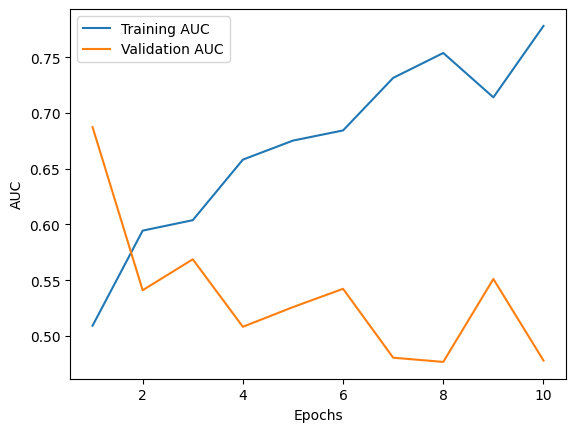

Learning Rate: 5e-05, Batch Size: 8, Validation AUC: 0.6872635561160151
Epoch: 1/10 | Avg Train Loss: 0.6906 | Train AUC: 0.5197
Validation Loss: 0.6905 | Validation AUC: 0.5876
Epoch: 2/10 | Avg Train Loss: 0.6839 | Train AUC: 0.5842
Validation Loss: 0.6901 | Validation AUC: 0.5397
Epoch: 3/10 | Avg Train Loss: 0.6609 | Train AUC: 0.6635
Validation Loss: 0.6876 | Validation AUC: 0.4943
Epoch: 4/10 | Avg Train Loss: 0.6782 | Train AUC: 0.6938
Validation Loss: 0.6839 | Validation AUC: 0.4805
Epoch: 5/10 | Avg Train Loss: 0.6916 | Train AUC: 0.7246
Validation Loss: 0.6922 | Validation AUC: 0.4061
Epoch: 6/10 | Avg Train Loss: 0.6554 | Train AUC: 0.7045
Validation Loss: 0.6780 | Validation AUC: 0.4842
Epoch: 7/10 | Avg Train Loss: 0.6560 | Train AUC: 0.7203
Validation Loss: 0.6842 | Validation AUC: 0.4035
Epoch: 8/10 | Avg Train Loss: 0.6528 | Train AUC: 0.7415
Validation Loss: 0.6910 | Validation AUC: 0.3783
Epoch: 9/10 | Avg Train Loss: 0.6416 | Train AUC: 0.7474
Validation Loss: 0.6847

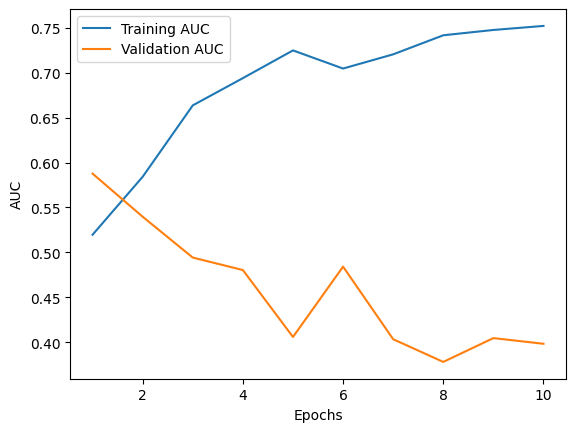

Learning Rate: 5e-05, Batch Size: 16, Validation AUC: 0.587641866330391
Epoch: 1/10 | Avg Train Loss: 0.7219 | Train AUC: 0.5198
Validation Loss: 0.7048 | Validation AUC: 0.4124
Epoch: 2/10 | Avg Train Loss: 0.6992 | Train AUC: 0.5051
Validation Loss: 0.7060 | Validation AUC: 0.3972
Epoch: 3/10 | Avg Train Loss: 0.7005 | Train AUC: 0.5204
Validation Loss: 0.7062 | Validation AUC: 0.4376
Epoch: 4/10 | Avg Train Loss: 0.6967 | Train AUC: 0.5354
Validation Loss: 0.7057 | Validation AUC: 0.4741
Epoch: 5/10 | Avg Train Loss: 0.6982 | Train AUC: 0.5474
Validation Loss: 0.7048 | Validation AUC: 0.5233
Epoch: 6/10 | Avg Train Loss: 0.6756 | Train AUC: 0.5558
Validation Loss: 0.7039 | Validation AUC: 0.5032
Epoch: 7/10 | Avg Train Loss: 0.6922 | Train AUC: 0.5654
Validation Loss: 0.7012 | Validation AUC: 0.4931
Epoch: 8/10 | Avg Train Loss: 0.6767 | Train AUC: 0.5694
Validation Loss: 0.6997 | Validation AUC: 0.4805
Epoch: 9/10 | Avg Train Loss: 0.6803 | Train AUC: 0.5703
Validation Loss: 0.6977

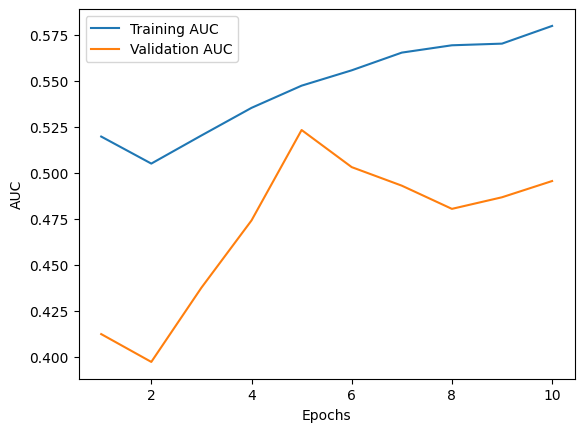

Learning Rate: 5e-05, Batch Size: 32, Validation AUC: 0.5233291298865069
Epoch: 1/10 | Avg Train Loss: 0.6975 | Train AUC: 0.5042
Validation Loss: 0.6941 | Validation AUC: 0.5132
Epoch: 2/10 | Avg Train Loss: 0.7140 | Train AUC: 0.4221
Validation Loss: 0.6917 | Validation AUC: 0.4565
Epoch: 3/10 | Avg Train Loss: 0.7020 | Train AUC: 0.4238
Validation Loss: 0.6902 | Validation AUC: 0.4363
Epoch: 4/10 | Avg Train Loss: 0.7051 | Train AUC: 0.4544
Validation Loss: 0.6893 | Validation AUC: 0.4086
Epoch: 5/10 | Avg Train Loss: 0.6967 | Train AUC: 0.5169
Validation Loss: 0.6890 | Validation AUC: 0.4010
Epoch: 6/10 | Avg Train Loss: 0.6882 | Train AUC: 0.5437
Validation Loss: 0.6887 | Validation AUC: 0.3909
Epoch: 7/10 | Avg Train Loss: 0.6957 | Train AUC: 0.5688
Validation Loss: 0.6892 | Validation AUC: 0.3682
Epoch: 8/10 | Avg Train Loss: 0.6910 | Train AUC: 0.5726
Validation Loss: 0.6899 | Validation AUC: 0.3619
Epoch: 9/10 | Avg Train Loss: 0.6858 | Train AUC: 0.5819
Validation Loss: 0.690

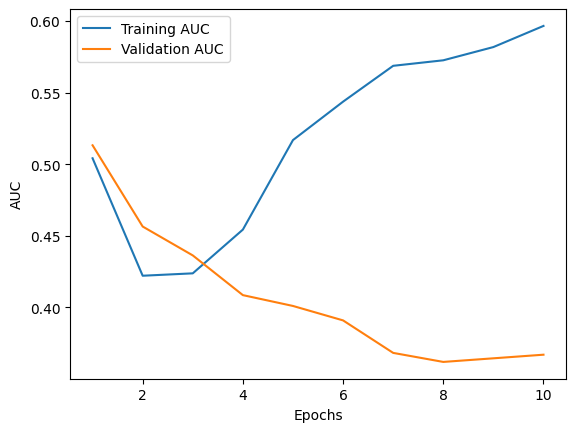

Learning Rate: 5e-05, Batch Size: 64, Validation AUC: 0.5132408575031526
Epoch: 1/10 | Avg Train Loss: 0.5776 | Train AUC: 0.5088
Validation Loss: 0.5390 | Validation AUC: 0.6797
Epoch: 2/10 | Avg Train Loss: 0.5435 | Train AUC: 0.6264
Validation Loss: 0.5959 | Validation AUC: 0.6356
Epoch: 3/10 | Avg Train Loss: 0.4797 | Train AUC: 0.6002
Validation Loss: 0.5672 | Validation AUC: 0.6381
Epoch: 4/10 | Avg Train Loss: 0.4537 | Train AUC: 0.7976
Validation Loss: 0.6694 | Validation AUC: 0.6431
Epoch: 5/10 | Avg Train Loss: 0.4754 | Train AUC: 0.5992
Validation Loss: 0.5453 | Validation AUC: 0.6948
Epoch: 6/10 | Avg Train Loss: 0.4538 | Train AUC: 0.7281
Validation Loss: 0.5895 | Validation AUC: 0.6923
Epoch: 7/10 | Avg Train Loss: 0.4472 | Train AUC: 0.7571
Validation Loss: 0.5888 | Validation AUC: 0.6999
Epoch: 8/10 | Avg Train Loss: 0.4535 | Train AUC: 0.7942
Validation Loss: 0.6041 | Validation AUC: 0.6129
Epoch: 9/10 | Avg Train Loss: 0.4237 | Train AUC: 0.8523
Validation Loss: 0.617

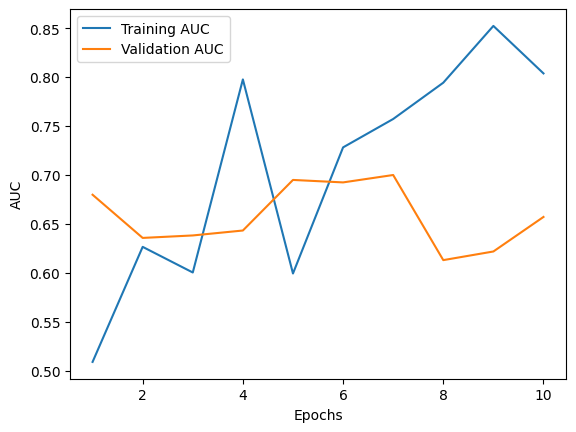

Learning Rate: 0.0001, Batch Size: 1, Validation AUC: 0.699873896595208
Epoch: 1/10 | Avg Train Loss: 0.7254 | Train AUC: 0.5598
Validation Loss: 0.6923 | Validation AUC: 0.4931
Epoch: 2/10 | Avg Train Loss: 0.6673 | Train AUC: 0.6470
Validation Loss: 0.6798 | Validation AUC: 0.5296
Epoch: 3/10 | Avg Train Loss: 0.6642 | Train AUC: 0.7221
Validation Loss: 0.6803 | Validation AUC: 0.5057
Epoch: 4/10 | Avg Train Loss: 0.6429 | Train AUC: 0.7526
Validation Loss: 0.6687 | Validation AUC: 0.5422
Epoch: 5/10 | Avg Train Loss: 0.6567 | Train AUC: 0.7637
Validation Loss: 0.6918 | Validation AUC: 0.4653
Epoch: 6/10 | Avg Train Loss: 0.6362 | Train AUC: 0.7675
Validation Loss: 0.6890 | Validation AUC: 0.4830
Epoch: 7/10 | Avg Train Loss: 0.6048 | Train AUC: 0.8304
Validation Loss: 0.6592 | Validation AUC: 0.5561
Epoch: 8/10 | Avg Train Loss: 0.5872 | Train AUC: 0.8125
Validation Loss: 0.6726 | Validation AUC: 0.5259
Epoch: 9/10 | Avg Train Loss: 0.5744 | Train AUC: 0.8488
Validation Loss: 0.6414

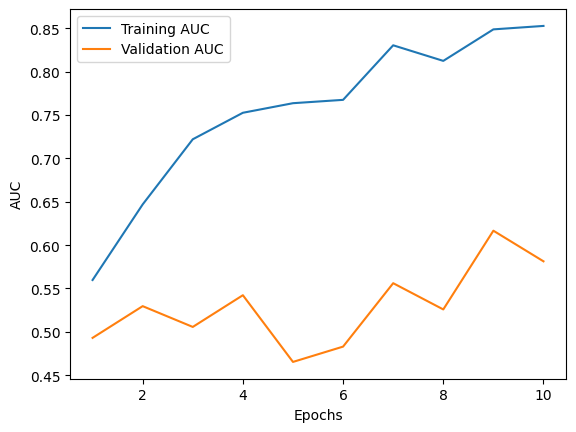

Learning Rate: 0.0001, Batch Size: 8, Validation AUC: 0.6166456494325346
Epoch: 1/10 | Avg Train Loss: 0.6924 | Train AUC: 0.5043
Validation Loss: 0.6834 | Validation AUC: 0.4363
Epoch: 2/10 | Avg Train Loss: 0.6863 | Train AUC: 0.6223
Validation Loss: 0.6839 | Validation AUC: 0.4098
Epoch: 3/10 | Avg Train Loss: 0.6875 | Train AUC: 0.6748
Validation Loss: 0.6826 | Validation AUC: 0.4426
Epoch: 4/10 | Avg Train Loss: 0.6696 | Train AUC: 0.7027
Validation Loss: 0.6884 | Validation AUC: 0.3745
Epoch: 5/10 | Avg Train Loss: 0.6633 | Train AUC: 0.7167
Validation Loss: 0.6802 | Validation AUC: 0.4767
Epoch: 6/10 | Avg Train Loss: 0.6457 | Train AUC: 0.7273
Validation Loss: 0.7001 | Validation AUC: 0.3632
Epoch: 7/10 | Avg Train Loss: 0.6475 | Train AUC: 0.7444
Validation Loss: 0.6838 | Validation AUC: 0.4401
Epoch: 8/10 | Avg Train Loss: 0.6377 | Train AUC: 0.7602
Validation Loss: 0.6853 | Validation AUC: 0.4174
Epoch: 9/10 | Avg Train Loss: 0.6306 | Train AUC: 0.7388
Validation Loss: 0.697

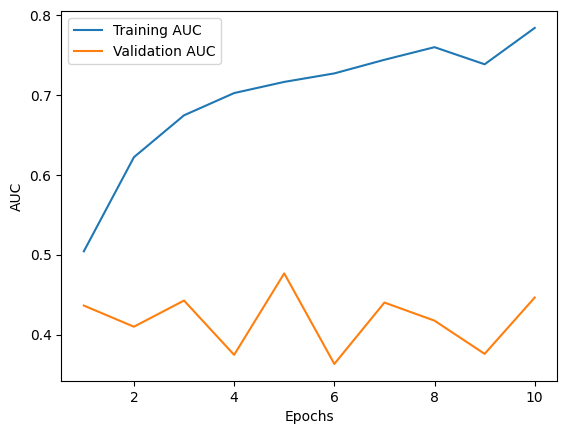

Learning Rate: 0.0001, Batch Size: 16, Validation AUC: 0.4766708701134931
Epoch: 1/10 | Avg Train Loss: 0.7066 | Train AUC: 0.4689
Validation Loss: 0.6912 | Validation AUC: 0.3884
Epoch: 2/10 | Avg Train Loss: 0.6967 | Train AUC: 0.4702
Validation Loss: 0.6888 | Validation AUC: 0.4855
Epoch: 3/10 | Avg Train Loss: 0.6956 | Train AUC: 0.5209
Validation Loss: 0.6875 | Validation AUC: 0.5019
Epoch: 4/10 | Avg Train Loss: 0.6826 | Train AUC: 0.5672
Validation Loss: 0.6866 | Validation AUC: 0.5246
Epoch: 5/10 | Avg Train Loss: 0.6741 | Train AUC: 0.6086
Validation Loss: 0.6867 | Validation AUC: 0.4792
Epoch: 6/10 | Avg Train Loss: 0.6809 | Train AUC: 0.6554
Validation Loss: 0.6887 | Validation AUC: 0.4174
Epoch: 7/10 | Avg Train Loss: 0.6694 | Train AUC: 0.6843
Validation Loss: 0.6861 | Validation AUC: 0.4073
Epoch: 8/10 | Avg Train Loss: 0.6633 | Train AUC: 0.6952
Validation Loss: 0.6852 | Validation AUC: 0.4061
Epoch: 9/10 | Avg Train Loss: 0.6660 | Train AUC: 0.7144
Validation Loss: 0.68

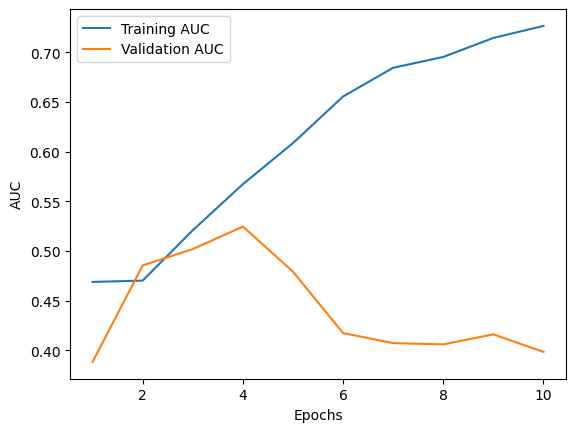

Learning Rate: 0.0001, Batch Size: 32, Validation AUC: 0.5245901639344263
Epoch: 1/10 | Avg Train Loss: 0.7126 | Train AUC: 0.4712
Validation Loss: 0.6879 | Validation AUC: 0.6444
Epoch: 2/10 | Avg Train Loss: 0.7132 | Train AUC: 0.4790
Validation Loss: 0.6880 | Validation AUC: 0.6494
Epoch: 3/10 | Avg Train Loss: 0.7084 | Train AUC: 0.4820
Validation Loss: 0.6882 | Validation AUC: 0.6318
Epoch: 4/10 | Avg Train Loss: 0.6902 | Train AUC: 0.4922
Validation Loss: 0.6883 | Validation AUC: 0.6141
Epoch: 5/10 | Avg Train Loss: 0.6942 | Train AUC: 0.5065
Validation Loss: 0.6883 | Validation AUC: 0.6003
Epoch: 6/10 | Avg Train Loss: 0.6948 | Train AUC: 0.5116
Validation Loss: 0.6878 | Validation AUC: 0.6116
Epoch: 7/10 | Avg Train Loss: 0.6950 | Train AUC: 0.5430
Validation Loss: 0.6878 | Validation AUC: 0.5712
Epoch: 8/10 | Avg Train Loss: 0.6892 | Train AUC: 0.5749
Validation Loss: 0.6873 | Validation AUC: 0.5624
Epoch: 9/10 | Avg Train Loss: 0.6885 | Train AUC: 0.6030
Validation Loss: 0.68

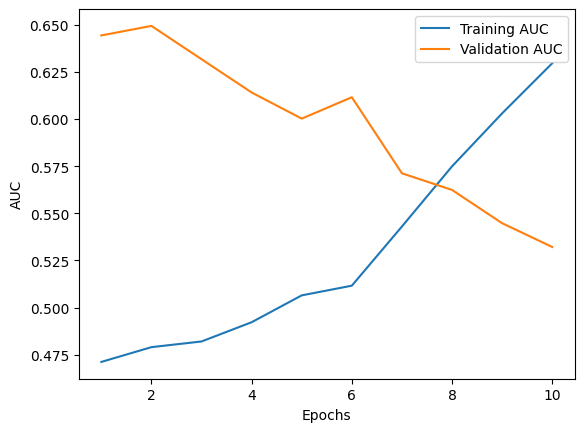

Learning Rate: 0.0001, Batch Size: 64, Validation AUC: 0.6494325346784363
Epoch: 1/10 | Avg Train Loss: 0.6088 | Train AUC: 0.5151
Validation Loss: 0.5376 | Validation AUC: 0.5977
Epoch: 2/10 | Avg Train Loss: 0.5305 | Train AUC: 0.4931
Validation Loss: 0.5926 | Validation AUC: 0.6431
Epoch: 3/10 | Avg Train Loss: 0.5307 | Train AUC: 0.5310
Validation Loss: 0.5724 | Validation AUC: 0.6230
Epoch: 4/10 | Avg Train Loss: 0.5169 | Train AUC: 0.5446
Validation Loss: 0.5725 | Validation AUC: 0.5725
Epoch: 5/10 | Avg Train Loss: 0.5692 | Train AUC: 0.5098
Validation Loss: 0.5226 | Validation AUC: 0.5662
Epoch: 6/10 | Avg Train Loss: 0.5432 | Train AUC: 0.5427
Validation Loss: 0.5968 | Validation AUC: 0.4830
Epoch: 7/10 | Avg Train Loss: 0.5281 | Train AUC: 0.5578
Validation Loss: 0.5319 | Validation AUC: 0.5801
Epoch: 8/10 | Avg Train Loss: 0.4966 | Train AUC: 0.6904
Validation Loss: 0.5926 | Validation AUC: 0.4603
Epoch: 9/10 | Avg Train Loss: 0.5011 | Train AUC: 0.7578
Validation Loss: 0.58

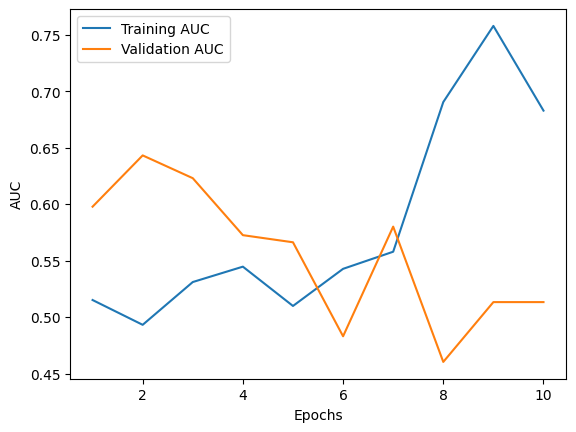

Learning Rate: 0.001, Batch Size: 1, Validation AUC: 0.6431273644388398
Epoch: 1/10 | Avg Train Loss: 0.7914 | Train AUC: 0.5779
Validation Loss: 0.6913 | Validation AUC: 0.3581
Epoch: 2/10 | Avg Train Loss: 0.7237 | Train AUC: 0.7399
Validation Loss: 0.6657 | Validation AUC: 0.4641
Epoch: 3/10 | Avg Train Loss: 0.6528 | Train AUC: 0.7032
Validation Loss: 0.6934 | Validation AUC: 0.4565
Epoch: 4/10 | Avg Train Loss: 0.6347 | Train AUC: 0.7611
Validation Loss: 0.6826 | Validation AUC: 0.4729
Epoch: 5/10 | Avg Train Loss: 0.6129 | Train AUC: 0.8093
Validation Loss: 0.6720 | Validation AUC: 0.4628
Epoch: 6/10 | Avg Train Loss: 0.5688 | Train AUC: 0.7958
Validation Loss: 0.6801 | Validation AUC: 0.5208
Epoch: 7/10 | Avg Train Loss: 0.5507 | Train AUC: 0.8346
Validation Loss: 0.6505 | Validation AUC: 0.5549
Epoch: 8/10 | Avg Train Loss: 0.6462 | Train AUC: 0.7371
Validation Loss: 0.7121 | Validation AUC: 0.5019
Epoch: 9/10 | Avg Train Loss: 0.6120 | Train AUC: 0.8245
Validation Loss: 0.6715

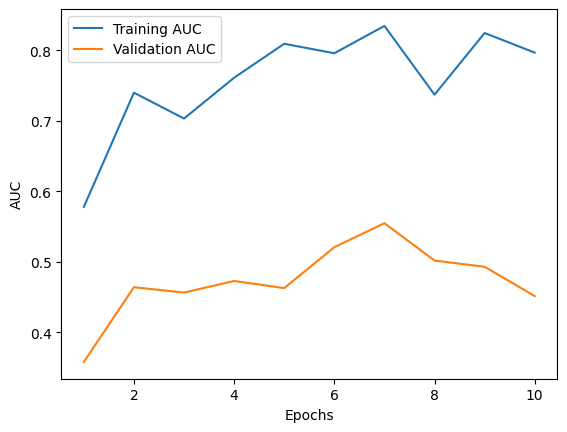

Learning Rate: 0.001, Batch Size: 8, Validation AUC: 0.5548549810844893
Epoch: 1/10 | Avg Train Loss: 0.7160 | Train AUC: 0.7232
Validation Loss: 0.6829 | Validation AUC: 0.4943
Epoch: 2/10 | Avg Train Loss: 0.6686 | Train AUC: 0.7300
Validation Loss: 0.6686 | Validation AUC: 0.4552
Epoch: 3/10 | Avg Train Loss: 0.6808 | Train AUC: 0.7582
Validation Loss: 0.6756 | Validation AUC: 0.4855
Epoch: 4/10 | Avg Train Loss: 0.7795 | Train AUC: 0.6996
Validation Loss: 0.7239 | Validation AUC: 0.4161
Epoch: 5/10 | Avg Train Loss: 0.6234 | Train AUC: 0.7516
Validation Loss: 0.7147 | Validation AUC: 0.4199
Epoch: 6/10 | Avg Train Loss: 0.6031 | Train AUC: 0.8055
Validation Loss: 0.6773 | Validation AUC: 0.4615
Epoch: 7/10 | Avg Train Loss: 0.5622 | Train AUC: 0.8620
Validation Loss: 0.6347 | Validation AUC: 0.6456
Epoch: 8/10 | Avg Train Loss: 0.5497 | Train AUC: 0.8591
Validation Loss: 0.6632 | Validation AUC: 0.5473
Epoch: 9/10 | Avg Train Loss: 0.5524 | Train AUC: 0.8705
Validation Loss: 0.6702

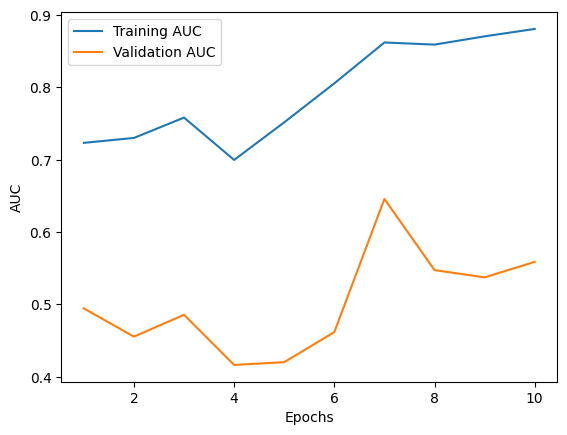

Learning Rate: 0.001, Batch Size: 16, Validation AUC: 0.6456494325346783
Epoch: 1/10 | Avg Train Loss: 0.7209 | Train AUC: 0.5856
Validation Loss: 0.6994 | Validation AUC: 0.3960
Epoch: 2/10 | Avg Train Loss: 0.6794 | Train AUC: 0.6653
Validation Loss: 0.6943 | Validation AUC: 0.4754
Epoch: 3/10 | Avg Train Loss: 0.6343 | Train AUC: 0.7177
Validation Loss: 0.6878 | Validation AUC: 0.5750
Epoch: 4/10 | Avg Train Loss: 0.6542 | Train AUC: 0.8004
Validation Loss: 0.6843 | Validation AUC: 0.5158
Epoch: 5/10 | Avg Train Loss: 0.6180 | Train AUC: 0.8057
Validation Loss: 0.6836 | Validation AUC: 0.4666
Epoch: 6/10 | Avg Train Loss: 0.5883 | Train AUC: 0.8552
Validation Loss: 0.6725 | Validation AUC: 0.5700
Epoch: 7/10 | Avg Train Loss: 0.5869 | Train AUC: 0.7919
Validation Loss: 0.7053 | Validation AUC: 0.4086
Epoch: 8/10 | Avg Train Loss: 0.5554 | Train AUC: 0.8771
Validation Loss: 0.6661 | Validation AUC: 0.5889
Epoch: 9/10 | Avg Train Loss: 0.5198 | Train AUC: 0.8880
Validation Loss: 0.663

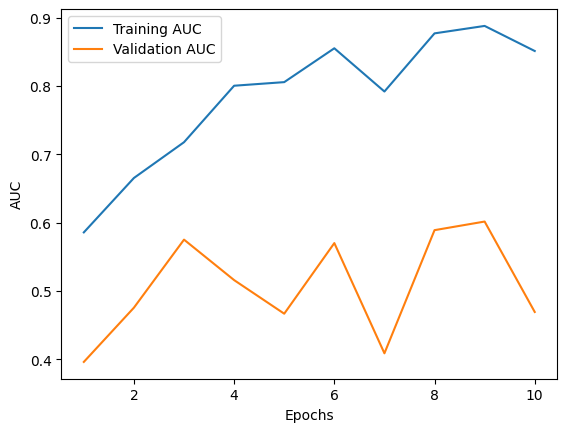

Learning Rate: 0.001, Batch Size: 32, Validation AUC: 0.6015132408575031
Epoch: 1/10 | Avg Train Loss: 0.7010 | Train AUC: 0.5195
Validation Loss: 0.6996 | Validation AUC: 0.5032
Epoch: 2/10 | Avg Train Loss: 0.7118 | Train AUC: 0.5683
Validation Loss: 0.6985 | Validation AUC: 0.5687
Epoch: 3/10 | Avg Train Loss: 0.6853 | Train AUC: 0.5923
Validation Loss: 0.6970 | Validation AUC: 0.5574
Epoch: 4/10 | Avg Train Loss: 0.6735 | Train AUC: 0.6357
Validation Loss: 0.6970 | Validation AUC: 0.4968
Epoch: 5/10 | Avg Train Loss: 0.6317 | Train AUC: 0.6875
Validation Loss: 0.6901 | Validation AUC: 0.6646
Epoch: 6/10 | Avg Train Loss: 0.6269 | Train AUC: 0.7046
Validation Loss: 0.6883 | Validation AUC: 0.6015
Epoch: 7/10 | Avg Train Loss: 0.6217 | Train AUC: 0.7334
Validation Loss: 0.6853 | Validation AUC: 0.5435
Epoch: 8/10 | Avg Train Loss: 0.5800 | Train AUC: 0.7937
Validation Loss: 0.6729 | Validation AUC: 0.6305
Epoch: 9/10 | Avg Train Loss: 0.6015 | Train AUC: 0.8036
Validation Loss: 0.677

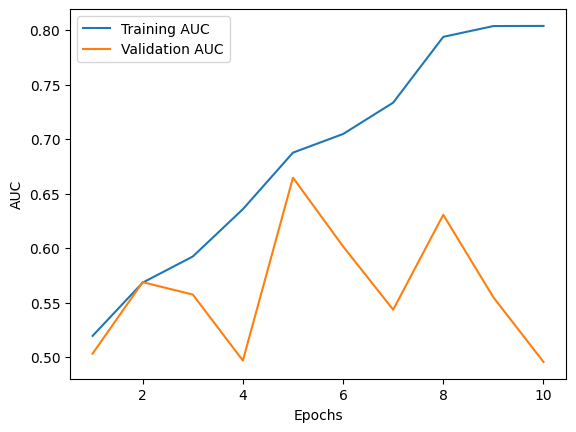

Learning Rate: 0.001, Batch Size: 64, Validation AUC: 0.6645649432534678
Error with LR 0.01 and Batch Size 1: Input contains NaN.
Epoch: 1/10 | Avg Train Loss: 0.9977 | Train AUC: 0.4224
Validation Loss: 0.7656 | Validation AUC: 0.4451
Epoch: 2/10 | Avg Train Loss: 1.2756 | Train AUC: 0.5803
Validation Loss: 0.7302 | Validation AUC: 0.3493
Epoch: 3/10 | Avg Train Loss: 2.5788 | Train AUC: 0.5155
Validation Loss: 0.7667 | Validation AUC: 0.4313
Epoch: 4/10 | Avg Train Loss: 3.2642 | Train AUC: 0.5229
Validation Loss: 0.7229 | Validation AUC: 0.4010
Epoch: 5/10 | Avg Train Loss: 0.9672 | Train AUC: 0.5348
Validation Loss: 0.7594 | Validation AUC: 0.4275
Epoch: 6/10 | Avg Train Loss: 0.7187 | Train AUC: 0.4825
Validation Loss: 0.6780 | Validation AUC: 0.5990
Epoch: 7/10 | Avg Train Loss: 0.6894 | Train AUC: 0.5547
Validation Loss: 0.6732 | Validation AUC: 0.4344
Epoch: 8/10 | Avg Train Loss: 0.6924 | Train AUC: 0.5321
Validation Loss: 0.6746 | Validation AUC: 0.4407
Epoch: 9/10 | Avg Trai

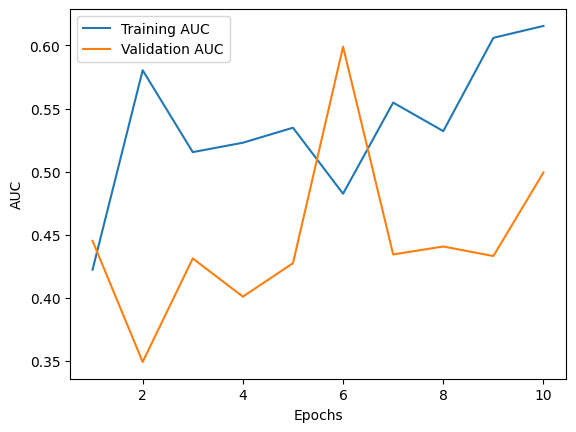

Learning Rate: 0.01, Batch Size: 8, Validation AUC: 0.5989911727616646
Epoch: 1/10 | Avg Train Loss: 0.8917 | Train AUC: 0.5310
Validation Loss: 0.7138 | Validation AUC: 0.4187
Epoch: 2/10 | Avg Train Loss: 0.7790 | Train AUC: 0.5564
Validation Loss: 0.7436 | Validation AUC: 0.3947
Epoch: 3/10 | Avg Train Loss: 0.7296 | Train AUC: 0.6101
Validation Loss: 0.7854 | Validation AUC: 0.3317
Epoch: 4/10 | Avg Train Loss: 0.7051 | Train AUC: 0.6859
Validation Loss: 0.7221 | Validation AUC: 0.3846
Epoch: 5/10 | Avg Train Loss: 0.6889 | Train AUC: 0.7062
Validation Loss: 0.6952 | Validation AUC: 0.3960
Epoch: 6/10 | Avg Train Loss: 0.6763 | Train AUC: 0.7205
Validation Loss: 0.7093 | Validation AUC: 0.4149
Epoch: 7/10 | Avg Train Loss: 0.6450 | Train AUC: 0.6960
Validation Loss: 0.6644 | Validation AUC: 0.5019
Epoch: 8/10 | Avg Train Loss: 0.6692 | Train AUC: 0.6310
Validation Loss: 0.6466 | Validation AUC: 0.5990
Epoch: 9/10 | Avg Train Loss: 0.7132 | Train AUC: 0.7155
Validation Loss: 0.6701 

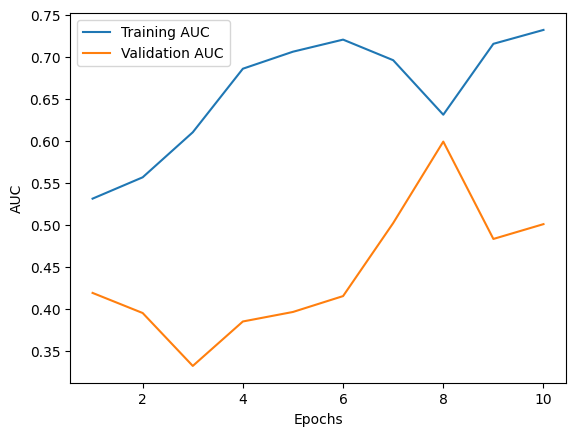

Learning Rate: 0.01, Batch Size: 16, Validation AUC: 0.5989911727616646
Epoch: 1/10 | Avg Train Loss: 0.7596 | Train AUC: 0.6596
Validation Loss: 0.6798 | Validation AUC: 0.3960
Epoch: 2/10 | Avg Train Loss: 0.8057 | Train AUC: 0.6540
Validation Loss: 0.7026 | Validation AUC: 0.4477
Epoch: 3/10 | Avg Train Loss: 0.6875 | Train AUC: 0.5883
Validation Loss: 0.6775 | Validation AUC: 0.6204
Epoch: 4/10 | Avg Train Loss: 0.6886 | Train AUC: 0.5846
Validation Loss: 0.6999 | Validation AUC: 0.3581
Epoch: 5/10 | Avg Train Loss: 0.6806 | Train AUC: 0.7254
Validation Loss: 0.6794 | Validation AUC: 0.4792
Epoch: 6/10 | Avg Train Loss: 0.6435 | Train AUC: 0.6918
Validation Loss: 0.7057 | Validation AUC: 0.4439
Epoch: 7/10 | Avg Train Loss: 0.6134 | Train AUC: 0.7730
Validation Loss: 0.6835 | Validation AUC: 0.4540
Epoch: 8/10 | Avg Train Loss: 0.6143 | Train AUC: 0.7363
Validation Loss: 0.7248 | Validation AUC: 0.4426
Epoch: 9/10 | Avg Train Loss: 0.5764 | Train AUC: 0.7770
Validation Loss: 0.6128

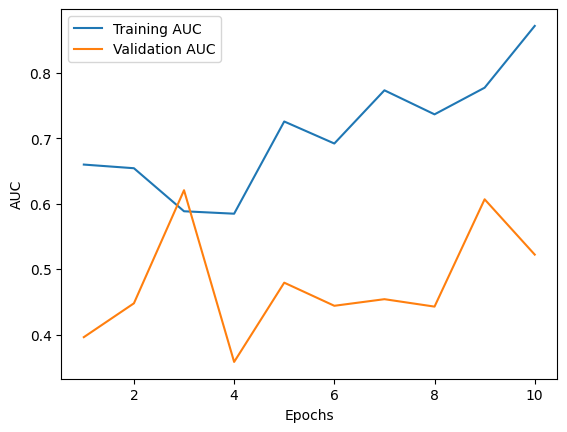

Learning Rate: 0.01, Batch Size: 32, Validation AUC: 0.6204287515762925
Epoch: 1/10 | Avg Train Loss: 0.7308 | Train AUC: 0.5307
Validation Loss: 0.6792 | Validation AUC: 0.1526
Epoch: 2/10 | Avg Train Loss: 0.8293 | Train AUC: 0.6391
Validation Loss: 0.6705 | Validation AUC: 0.3632
Epoch: 3/10 | Avg Train Loss: 0.7578 | Train AUC: 0.5901
Validation Loss: 0.6660 | Validation AUC: 0.6255
Epoch: 4/10 | Avg Train Loss: 0.7407 | Train AUC: 0.6169
Validation Loss: 0.6566 | Validation AUC: 0.6267
Epoch: 5/10 | Avg Train Loss: 0.7138 | Train AUC: 0.6833
Validation Loss: 0.6575 | Validation AUC: 0.6028
Epoch: 6/10 | Avg Train Loss: 0.6792 | Train AUC: 0.6814
Validation Loss: 0.6813 | Validation AUC: 0.3985
Epoch: 7/10 | Avg Train Loss: 0.6629 | Train AUC: 0.7321
Validation Loss: 0.6786 | Validation AUC: 0.3884
Epoch: 8/10 | Avg Train Loss: 0.6624 | Train AUC: 0.7478
Validation Loss: 0.6772 | Validation AUC: 0.4275
Epoch: 9/10 | Avg Train Loss: 0.6272 | Train AUC: 0.7325
Validation Loss: 0.7055

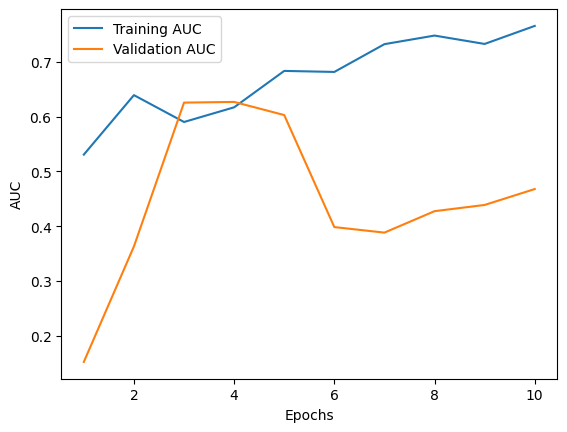

Learning Rate: 0.01, Batch Size: 64, Validation AUC: 0.626733921815889
Error with LR 0.1 and Batch Size 1: Input contains NaN.
Error with LR 0.1 and Batch Size 8: Input contains NaN.
Error with LR 0.1 and Batch Size 16: Input contains NaN.
Epoch: 1/10 | Avg Train Loss: 11.4111 | Train AUC: 0.4832
Validation Loss: 0.7004 | Validation AUC: 0.4590
Error with LR 0.1 and Batch Size 32: Input contains NaN.
Epoch: 1/10 | Avg Train Loss: 3.2065 | Train AUC: 0.5000
Validation Loss: 1.0601 | Validation AUC: 0.5000
Error with LR 0.1 and Batch Size 64: Input contains NaN.
Error with LR 1 and Batch Size 1: Input contains NaN.
Error with LR 1 and Batch Size 8: Input contains NaN.
Error with LR 1 and Batch Size 16: Input contains NaN.
Error with LR 1 and Batch Size 32: Input contains NaN.
Error with LR 1 and Batch Size 64: Input contains NaN.
Best Learning Rate: 5e-05, Best Batch Size: 1, Best Validation AUC: 0.7061790668348046


In [ ]:
import itertools
#in this grid search the goal is to find the hyperparameters that yeild the best AUC score when the baseline model is trained on a small number of epochs.
#in this case, I chose 10 epochs
# Define the grid search space
learning_rates = [5e-5, 1e-4, 1e-3, 1e-2, 0.1, 1]
batch_sizes = [1, 8, 16, 32, 64]
l2_penalty = 0.001
used_momentum = 0.9

best_auc = 0.0
best_lr = 0.0
best_batch_size = 0

# Perform grid search
for lr, batch_size in itertools.product(learning_rates, batch_sizes):
    # Set up your model, optimizer, and criterion here

    # Train the model for a small number of epochs
    num_epochs_search = 10
    train_loader_search = torch.utils.data.DataLoader(dataset=train_dset, batch_size=batch_size, shuffle=True)
    val_loader_search = torch.utils.data.DataLoader(dataset=val_dset, batch_size=batch_size, shuffle=False)

    model_search = NN3d(in_chans=1)
    if torch.cuda.is_available():
        model_search.cuda()

    optimizer_search = torch.optim.SGD(model_search.parameters(), lr=lr, momentum=used_momentum, weight_decay=l2_penalty)
    criterion_search = nn.CrossEntropyLoss(weight=class_weights)

    try:
        val_auc_search = train_epoch(model_search, optimizer_search, criterion_search, train_loader_search, val_loader_search, batch_size, num_epochs_search)

        print(f'Learning Rate: {lr}, Batch Size: {batch_size}, Validation AUC: {val_auc_search}')

        # Update the best hyperparameters if the current one gives a higher AUC
        if val_auc_search > best_auc:
            best_auc = val_auc_search
            best_lr = lr
            best_batch_size = batch_size

    except Exception as e:
        print(f"Error with LR {lr} and Batch Size {batch_size}: {e}")

print(f'Best Learning Rate: {best_lr}, Best Batch Size: {best_batch_size}, Best Validation AUC: {best_auc}')

##Hyperparameters based on grid search

The hyperparameters were adjusted based on the grid search performed above to yeild the best AUC scores. The best learning rate was 0.00005 or a batch size of 1 and yielded an AUC score of about 0.706179. The critical learning rate appears to be around 0.1 as the code begins to fail.

In [ ]:
batch_size = 1
learning_rate = 0.00005
l2_penalty = 0.001
used_momentum = 0.9
num_epochs = 40

## Optimizer

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=used_momentum, weight_decay=l2_penalty)

## Training and Validation


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dset,
                                           batch_size=batch_size,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dset,
                                         batch_size=batch_size,
                                         shuffle=False)

Epoch: 1/40 | Avg Train Loss: 0.5280 | Train AUC: 0.5534
Validation Loss: 0.5921 | Validation AUC: 0.6923
Epoch: 2/40 | Avg Train Loss: 0.5140 | Train AUC: 0.6186
Validation Loss: 0.5931 | Validation AUC: 0.6658
Epoch: 3/40 | Avg Train Loss: 0.4864 | Train AUC: 0.5816
Validation Loss: 0.5419 | Validation AUC: 0.6810
Epoch: 4/40 | Avg Train Loss: 0.4926 | Train AUC: 0.7860
Validation Loss: 0.6255 | Validation AUC: 0.6873
Epoch: 5/40 | Avg Train Loss: 0.4609 | Train AUC: 0.6805
Validation Loss: 0.5651 | Validation AUC: 0.6784
Epoch: 6/40 | Avg Train Loss: 0.4359 | Train AUC: 0.8799
Validation Loss: 0.6185 | Validation AUC: 0.7062
Epoch: 7/40 | Avg Train Loss: 0.4111 | Train AUC: 0.8484
Validation Loss: 0.6018 | Validation AUC: 0.6557
Epoch: 8/40 | Avg Train Loss: 0.4005 | Train AUC: 0.8945
Validation Loss: 0.6390 | Validation AUC: 0.5977
Epoch: 9/40 | Avg Train Loss: 0.3749 | Train AUC: 0.8393
Validation Loss: 0.5816 | Validation AUC: 0.6583
Epoch: 10/40 | Avg Train Loss: 0.3833 | Train 

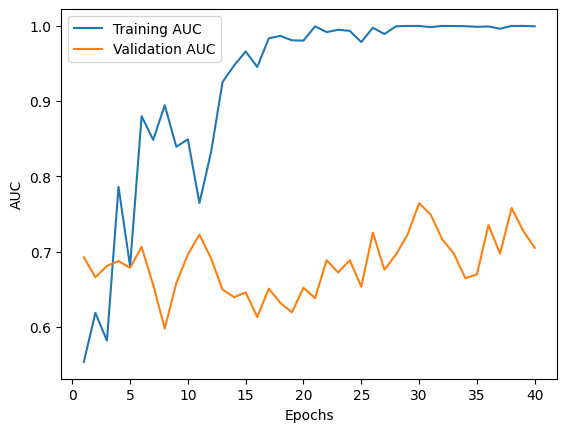

Best validation AUC is: 0.7641866330390921
Test AUC: 0.7167464114832536


In [ ]:
# Use the modified training and validation loop
best_val_auc = train_epoch(model, optimizer, criterion, train_loader, val_loader, batch_size, num_epochs)
print("Best validation AUC is:", best_val_auc)

# Load the best model based on validation AUC
best_model = torch.load('./models/best_model.pth')

# Evaluate on the test set
test_loader = torch.utils.data.DataLoader(dataset=test_dset, batch_size=batch_size, shuffle=False)
test_auc = calculate_auc(test_loader, best_model)
print("Test AUC:", test_auc)

It is to note that the test AUC dropped significantly relative to the test accuracy.

##Difference between accuracy and AUC




Accuracy and AUC both are measures of performance of classification models. Accuracy refers to the measurement that takes the ratio of correctly predicted instances to the total number of instances. AUC is a measure of the area under the ROC curve. It represents the trade-off between true positive rate and false positive. As mentioned in the previous question, the baseline accuracy is dependent on the proportion of the highest class. However, the AUC measure is not sensitive to the class proportions.

#Section 4: Reporting AUC in Different Scenarios

Baseline Model

Epoch: 1/40 | Avg Train Loss: 0.5342 | Train AUC: 0.5747
Validation Loss: 0.6140 | Validation AUC: 0.5725
Epoch: 2/40 | Avg Train Loss: 0.5134 | Train AUC: 0.5950
Validation Loss: 0.5967 | Validation AUC: 0.6646
Epoch: 3/40 | Avg Train Loss: 0.4867 | Train AUC: 0.7154
Validation Loss: 0.6464 | Validation AUC: 0.5839
Epoch: 4/40 | Avg Train Loss: 0.4538 | Train AUC: 0.8221
Validation Loss: 0.6591 | Validation AUC: 0.5763
Epoch: 5/40 | Avg Train Loss: 0.4481 | Train AUC: 0.6702
Validation Loss: 0.5650 | Validation AUC: 0.6822
Epoch: 6/40 | Avg Train Loss: 0.4341 | Train AUC: 0.7900
Validation Loss: 0.5995 | Validation AUC: 0.6381
Epoch: 7/40 | Avg Train Loss: 0.4236 | Train AUC: 0.8270
Validation Loss: 0.6042 | Validation AUC: 0.6646
Epoch: 8/40 | Avg Train Loss: 0.4061 | Train AUC: 0.8887
Validation Loss: 0.6176 | Validation AUC: 0.6482
Epoch: 9/40 | Avg Train Loss: 0.3889 | Train AUC: 0.8895
Validation Loss: 0.6540 | Validation AUC: 0.5322
Epoch: 10/40 | Avg Train Loss: 0.3633 | Train 

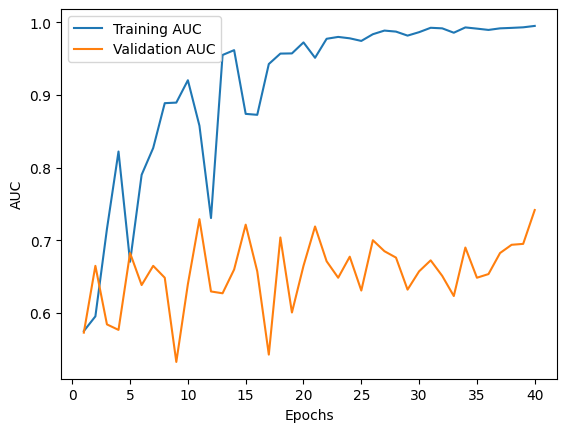

In [ ]:
baseline_model = NN3d(in_chans=1)
if torch.cuda.is_available():
    baseline_model.cuda()
baseline_optimizer = torch.optim.SGD(baseline_model.parameters(), lr=learning_rate, momentum=used_momentum, weight_decay=l2_penalty)
baseline_best_val_auc = train_epoch(baseline_model, baseline_optimizer, criterion, train_loader, val_loader, batch_size, num_epochs)

Adding a CNN module (convolution layer)

In [ ]:
class NN3dWithExtraCNN(nn.Module):
  def __init__(self, in_chans):
    super(NN3dWithExtraCNN, self).__init__()

    # Convolution 1
    self.cnn1 = nn.Conv3d(in_channels=in_chans,
                          out_channels=8,
                          kernel_size=5,
                          stride=1,
                          padding=0)

    self.bn1 = nn.BatchNorm3d(8)
    self.maxpool1 = nn.MaxPool3d(kernel_size=(2,2,2))
    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(p=0.1)

    # Convolution 2
    self.cnn2 = nn.Conv3d(in_channels=8,
                          out_channels=16,
                          kernel_size=3,
                          stride=1,
                          padding=0)
    self.bn2 = nn.BatchNorm3d(16)
    self.maxpool2 = nn.MaxPool3d(kernel_size=(2,2,2))
    self.relu2 = nn.ReLU()
    self.dropout2 = nn.Dropout(p=0.1)

    # Convolution 3
    self.cnn3 = nn.Conv3d(in_channels=16,
                          out_channels=32,
                          kernel_size=3,
                          stride=1,
                          padding=0)
    self.bn3 = nn.BatchNorm3d(32)
    self.maxpool3 = nn.MaxPool3d(kernel_size=(2,2,2))
    self.relu3 = nn.ReLU()
    self.dropout3 = nn.Dropout(p=0.1)

    # Convolution 4
    self.cnn4 = nn.Conv3d(in_channels=32,
                          out_channels=64,
                          kernel_size=3,
                          stride=1,
                          padding=0)
    self.bn4 = nn.BatchNorm3d(64)
    self.maxpool4 = nn.MaxPool3d(kernel_size=(2,2,2))
    self.relu4 = nn.ReLU()
    self.dropout4 = nn.Dropout(p=0.1)

    # Convolution 5
    self.cnn5 = nn.Conv3d(in_channels=64,
                          out_channels=128,
                          kernel_size=2,
                          stride=1,
                          padding=0)
    self.bn5 = nn.BatchNorm3d(128)
    # self.maxpool5 = nn.MaxPool3d(kernel_size=(2,2,2))
    self.relu5 = nn.ReLU()
    self.dropout5 = nn.Dropout(p=0.1)

    # Fully connected Layers
    self.fc1 = nn.Linear(2688, 1024)
    self.fc2 = nn.Linear(1024, 128)
    self.fc3 = nn.Linear(128, 2)

  def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.bn1(out)
        out = self.maxpool1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        # Convolution 2
        out = self.cnn2(out)
        out = self.bn2(out)
        out = self.maxpool2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        # Convolution 3
        out = self.cnn3(out)
        out = self.bn3(out)
        out = self.maxpool3(out)
        out = self.relu3(out)
        out = self.dropout3(out)

        # Convolution 4
        out = self.cnn4(out)
        out = self.bn4(out)
        out = self.maxpool4(out)
        out = self.relu4(out)
        out = self.dropout4(out)

        # Convolution 5
        out = self.cnn5(out)
        out = self.bn5(out)
        # out = self.maxpool5(out)
        out = self.relu5(out)
        out = self.dropout5(out)

        out = out.view(out.size(0), -1)

        # Linear function
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

Epoch: 1/40 | Avg Train Loss: 0.5190 | Train AUC: 0.5155
Validation Loss: 0.5515 | Validation AUC: 0.6419
Epoch: 2/40 | Avg Train Loss: 0.4952 | Train AUC: 0.5618
Validation Loss: 0.5783 | Validation AUC: 0.6318
Epoch: 3/40 | Avg Train Loss: 0.4865 | Train AUC: 0.6165
Validation Loss: 0.5550 | Validation AUC: 0.5939
Epoch: 4/40 | Avg Train Loss: 0.4980 | Train AUC: 0.6258
Validation Loss: 0.5456 | Validation AUC: 0.6406
Epoch: 5/40 | Avg Train Loss: 0.4789 | Train AUC: 0.7248
Validation Loss: 0.5540 | Validation AUC: 0.6166
Epoch: 6/40 | Avg Train Loss: 0.4617 | Train AUC: 0.7019
Validation Loss: 0.5459 | Validation AUC: 0.5876
Epoch: 7/40 | Avg Train Loss: 0.4693 | Train AUC: 0.8235
Validation Loss: 0.5695 | Validation AUC: 0.5246
Epoch: 8/40 | Avg Train Loss: 0.4492 | Train AUC: 0.8507
Validation Loss: 0.5579 | Validation AUC: 0.5574
Epoch: 9/40 | Avg Train Loss: 0.4400 | Train AUC: 0.8126
Validation Loss: 0.5477 | Validation AUC: 0.6028
Epoch: 10/40 | Avg Train Loss: 0.4292 | Train 

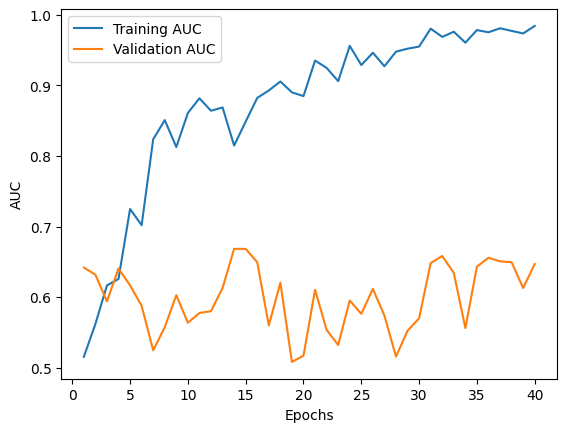

In [ ]:
# Create and train the model
model_with_extra_cnn = NN3dWithExtraCNN(in_chans=1)
if torch.cuda.is_available():
    model_with_extra_cnn.cuda()
optimizer_with_extra_cnn = torch.optim.SGD(model_with_extra_cnn.parameters(), lr=learning_rate, momentum=used_momentum, weight_decay=l2_penalty)
best_val_auc_with_extra_cnn = train_epoch(model_with_extra_cnn, optimizer_with_extra_cnn, criterion, train_loader, val_loader, batch_size, num_epochs)

Removing a CNN module (convolution layer)

In [ ]:
class NN3dWithRemovedCNN(nn.Module):
  def __init__(self, in_chans):
    super(NN3dWithRemovedCNN, self).__init__()

    # Convolution 1
    self.cnn1 = nn.Conv3d(in_channels=in_chans,
                          out_channels=8,
                          kernel_size=5,
                          stride=1,
                          padding=0)

    self.bn1 = nn.BatchNorm3d(8)
    self.maxpool1 = nn.MaxPool3d(kernel_size=(2,2,2))
    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(p=0.1)

    # Convolution 2
    self.cnn2 = nn.Conv3d(in_channels=8,
                          out_channels=16,
                          kernel_size=3,
                          stride=1,
                          padding=0)
    self.bn2 = nn.BatchNorm3d(16)
    self.maxpool2 = nn.MaxPool3d(kernel_size=(2,2,2))
    self.relu2 = nn.ReLU()
    self.dropout2 = nn.Dropout(p=0.1)

    # Convolution 3
    self.cnn3 = nn.Conv3d(in_channels=16,
                          out_channels=32,
                          kernel_size=3,
                          stride=1,
                          padding=0)
    self.bn3 = nn.BatchNorm3d(32)
    self.maxpool3 = nn.MaxPool3d(kernel_size=(2,2,2))
    self.relu3 = nn.ReLU()
    self.dropout3 = nn.Dropout(p=0.1)

    # Fully connected Layers
    self.fc1 = nn.Linear(34560, 1024)
    self.fc2 = nn.Linear(1024, 128)
    self.fc3 = nn.Linear(128, 2)

  def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.bn1(out)
        out = self.maxpool1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        # Convolution 2
        out = self.cnn2(out)
        out = self.bn2(out)
        out = self.maxpool2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        # Convolution 3
        out = self.cnn3(out)
        out = self.bn3(out)
        out = self.maxpool3(out)
        out = self.relu3(out)
        out = self.dropout3(out)

        out = out.view(out.size(0), -1)

        # Linear function
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

Epoch: 1/40 | Avg Train Loss: 0.6272 | Train AUC: 0.6988
Validation Loss: 0.5545 | Validation AUC: 0.6242
Epoch: 2/40 | Avg Train Loss: 0.4871 | Train AUC: 0.7271
Validation Loss: 0.5487 | Validation AUC: 0.6217
Epoch: 3/40 | Avg Train Loss: 0.4283 | Train AUC: 0.8673
Validation Loss: 0.5658 | Validation AUC: 0.6204
Epoch: 4/40 | Avg Train Loss: 0.3952 | Train AUC: 0.9330
Validation Loss: 0.6252 | Validation AUC: 0.5902
Epoch: 5/40 | Avg Train Loss: 0.3534 | Train AUC: 0.8412
Validation Loss: 0.5254 | Validation AUC: 0.6305
Epoch: 6/40 | Avg Train Loss: 0.2677 | Train AUC: 0.9208
Validation Loss: 0.5593 | Validation AUC: 0.6343
Epoch: 7/40 | Avg Train Loss: 0.2925 | Train AUC: 0.9586
Validation Loss: 0.5484 | Validation AUC: 0.6368
Epoch: 8/40 | Avg Train Loss: 0.2564 | Train AUC: 0.9563
Validation Loss: 0.6254 | Validation AUC: 0.6406
Epoch: 9/40 | Avg Train Loss: 0.2568 | Train AUC: 0.9762
Validation Loss: 0.5545 | Validation AUC: 0.6381
Epoch: 10/40 | Avg Train Loss: 0.2130 | Train 

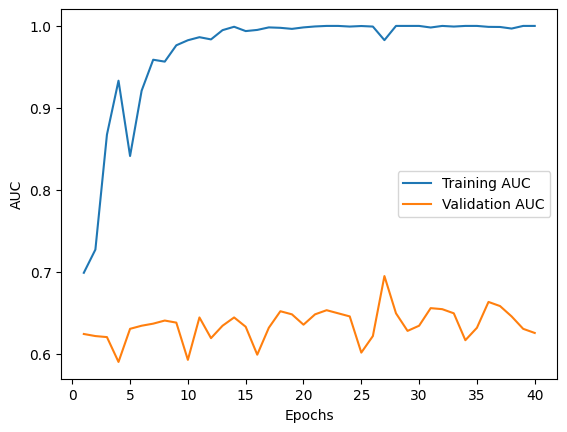

In [ ]:
model_without_one_cnn = NN3dWithRemovedCNN(in_chans=1)
if torch.cuda.is_available():
    model_without_one_cnn.cuda()
optimizer_without_one_cnn = torch.optim.SGD(model_without_one_cnn.parameters(), lr=learning_rate, momentum=used_momentum, weight_decay=l2_penalty)
best_val_auc_without_one_cnn = train_epoch(model_without_one_cnn, optimizer_without_one_cnn, criterion, train_loader, val_loader, batch_size, num_epochs)

Adding an FC Layer

In [ ]:
class NN3dWithExtraFC(nn.Module):
  def __init__(self, in_chans):
    super(NN3dWithExtraFC, self).__init__()

    # Convolution 1
    self.cnn1 = nn.Conv3d(in_channels=in_chans,
                          out_channels=8,
                          kernel_size=5,
                          stride=1,
                          padding=0)

    self.bn1 = nn.BatchNorm3d(8)
    self.maxpool1 = nn.MaxPool3d(kernel_size=(2,2,2))
    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(p=0.1)

    # Convolution 2
    self.cnn2 = nn.Conv3d(in_channels=8,
                          out_channels=16,
                          kernel_size=3,
                          stride=1,
                          padding=0)
    self.bn2 = nn.BatchNorm3d(16)
    self.maxpool2 = nn.MaxPool3d(kernel_size=(2,2,2))
    self.relu2 = nn.ReLU()
    self.dropout2 = nn.Dropout(p=0.1)

    # Convolution 3
    self.cnn3 = nn.Conv3d(in_channels=16,
                          out_channels=32,
                          kernel_size=3,
                          stride=1,
                          padding=0)
    self.bn3 = nn.BatchNorm3d(32)
    self.maxpool3 = nn.MaxPool3d(kernel_size=(2,2,2))
    self.relu3 = nn.ReLU()
    self.dropout3 = nn.Dropout(p=0.1)

    # Convolution 4
    self.cnn4 = nn.Conv3d(in_channels=32,
                          out_channels=64,
                          kernel_size=3,
                          stride=1,
                          padding=0)
    self.bn4 = nn.BatchNorm3d(64)
    self.maxpool4 = nn.MaxPool3d(kernel_size=(2,2,2))
    self.relu4 = nn.ReLU()
    self.dropout4 = nn.Dropout(p=0.1)

    # Fully connected Layers
    self.fc1 = nn.Linear(4096, 1024)
    self.fc2 = nn.Linear(1024, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 2)


  def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.bn1(out)
        out = self.maxpool1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        # Convolution 2
        out = self.cnn2(out)
        out = self.bn2(out)
        out = self.maxpool2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        # Convolution 3
        out = self.cnn3(out)
        out = self.bn3(out)
        out = self.maxpool3(out)
        out = self.relu3(out)
        out = self.dropout3(out)

        # Convolution 4
        out = self.cnn4(out)
        out = self.bn4(out)
        out = self.maxpool4(out)
        out = self.relu4(out)
        out = self.dropout4(out)

        out = out.view(out.size(0), -1)

        # Linear function
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)

        return out

Epoch: 1/40 | Avg Train Loss: 0.5292 | Train AUC: 0.5103
Validation Loss: 0.5739 | Validation AUC: 0.6696
Epoch: 2/40 | Avg Train Loss: 0.4917 | Train AUC: 0.5196
Validation Loss: 0.5682 | Validation AUC: 0.6671
Epoch: 3/40 | Avg Train Loss: 0.4937 | Train AUC: 0.5284
Validation Loss: 0.5609 | Validation AUC: 0.6747
Epoch: 4/40 | Avg Train Loss: 0.4774 | Train AUC: 0.5550
Validation Loss: 0.5701 | Validation AUC: 0.6557
Epoch: 5/40 | Avg Train Loss: 0.4682 | Train AUC: 0.5676
Validation Loss: 0.5623 | Validation AUC: 0.6696
Epoch: 6/40 | Avg Train Loss: 0.4655 | Train AUC: 0.5808
Validation Loss: 0.5655 | Validation AUC: 0.6936
Epoch: 7/40 | Avg Train Loss: 0.4654 | Train AUC: 0.6845
Validation Loss: 0.6023 | Validation AUC: 0.6620
Epoch: 8/40 | Avg Train Loss: 0.4508 | Train AUC: 0.5607
Validation Loss: 0.5357 | Validation AUC: 0.6772
Epoch: 9/40 | Avg Train Loss: 0.4494 | Train AUC: 0.6611
Validation Loss: 0.5912 | Validation AUC: 0.6810
Epoch: 10/40 | Avg Train Loss: 0.4395 | Train 

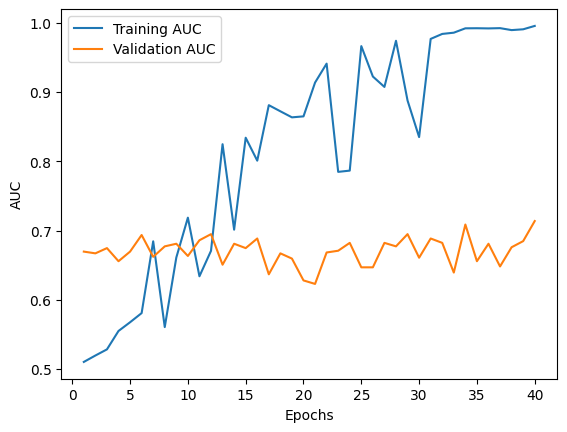

In [ ]:
# Create and train the model
model_with_extra_fc = NN3dWithExtraFC(in_chans=1)
if torch.cuda.is_available():
    model_with_extra_fc.cuda()
optimizer_with_extra_fc = torch.optim.SGD(model_with_extra_fc.parameters(), lr=learning_rate, momentum=used_momentum, weight_decay=l2_penalty)
best_val_auc_with_extra_fc = train_epoch(model_with_extra_fc, optimizer_with_extra_fc, criterion, train_loader, val_loader, batch_size, num_epochs)

Adding two FC layers

In [ ]:
class NN3dWithTwoExtraFC(nn.Module):
  def __init__(self, in_chans):
    super(NN3dWithTwoExtraFC, self).__init__()

    # Convolution 1
    self.cnn1 = nn.Conv3d(in_channels=in_chans,
                          out_channels=8,
                          kernel_size=5,
                          stride=1,
                          padding=0)

    self.bn1 = nn.BatchNorm3d(8)
    self.maxpool1 = nn.MaxPool3d(kernel_size=(2,2,2))
    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(p=0.1)

    # Convolution 2
    self.cnn2 = nn.Conv3d(in_channels=8,
                          out_channels=16,
                          kernel_size=3,
                          stride=1,
                          padding=0)
    self.bn2 = nn.BatchNorm3d(16)
    self.maxpool2 = nn.MaxPool3d(kernel_size=(2,2,2))
    self.relu2 = nn.ReLU()
    self.dropout2 = nn.Dropout(p=0.1)

    # Convolution 3
    self.cnn3 = nn.Conv3d(in_channels=16,
                          out_channels=32,
                          kernel_size=3,
                          stride=1,
                          padding=0)
    self.bn3 = nn.BatchNorm3d(32)
    self.maxpool3 = nn.MaxPool3d(kernel_size=(2,2,2))
    self.relu3 = nn.ReLU()
    self.dropout3 = nn.Dropout(p=0.1)

    # Convolution 4
    self.cnn4 = nn.Conv3d(in_channels=32,
                          out_channels=64,
                          kernel_size=3,
                          stride=1,
                          padding=0)
    self.bn4 = nn.BatchNorm3d(64)
    self.maxpool4 = nn.MaxPool3d(kernel_size=(2,2,2))
    self.relu4 = nn.ReLU()
    self.dropout4 = nn.Dropout(p=0.1)

    # Fully connected Layers
    self.fc1 = nn.Linear(4096, 1024)
    self.fc2 = nn.Linear(1024, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 32)
    self.fc5 = nn.Linear(32, 2)


  def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.bn1(out)
        out = self.maxpool1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        # Convolution 2
        out = self.cnn2(out)
        out = self.bn2(out)
        out = self.maxpool2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        # Convolution 3
        out = self.cnn3(out)
        out = self.bn3(out)
        out = self.maxpool3(out)
        out = self.relu3(out)
        out = self.dropout3(out)

        # Convolution 4
        out = self.cnn4(out)
        out = self.bn4(out)
        out = self.maxpool4(out)
        out = self.relu4(out)
        out = self.dropout4(out)

        out = out.view(out.size(0), -1)

        # Linear function
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        out = self.fc5(out)

        return out

Epoch: 1/40 | Avg Train Loss: 0.5192 | Train AUC: 0.5017
Validation Loss: 0.5723 | Validation AUC: 0.6633
Epoch: 2/40 | Avg Train Loss: 0.5033 | Train AUC: 0.5132
Validation Loss: 0.6050 | Validation AUC: 0.6570
Epoch: 3/40 | Avg Train Loss: 0.4962 | Train AUC: 0.5151
Validation Loss: 0.5887 | Validation AUC: 0.6583
Epoch: 4/40 | Avg Train Loss: 0.4949 | Train AUC: 0.5218
Validation Loss: 0.5753 | Validation AUC: 0.6620
Epoch: 5/40 | Avg Train Loss: 0.4912 | Train AUC: 0.5301
Validation Loss: 0.5908 | Validation AUC: 0.6595
Epoch: 6/40 | Avg Train Loss: 0.4815 | Train AUC: 0.5449
Validation Loss: 0.5947 | Validation AUC: 0.6507
Epoch: 7/40 | Avg Train Loss: 0.4881 | Train AUC: 0.5487
Validation Loss: 0.5855 | Validation AUC: 0.6557
Epoch: 8/40 | Avg Train Loss: 0.4851 | Train AUC: 0.5553
Validation Loss: 0.5867 | Validation AUC: 0.6557
Epoch: 9/40 | Avg Train Loss: 0.4712 | Train AUC: 0.5569
Validation Loss: 0.5829 | Validation AUC: 0.6620
Epoch: 10/40 | Avg Train Loss: 0.4743 | Train 

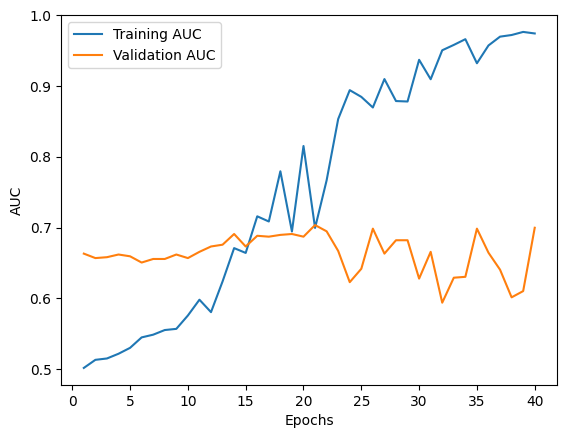

In [ ]:
model_with_two_extra_fc = NN3dWithTwoExtraFC(in_chans=1)
if torch.cuda.is_available():
    model_with_two_extra_fc.cuda()
optimizer_with_two_extra_fc = torch.optim.SGD(model_with_two_extra_fc.parameters(), lr=learning_rate, momentum=used_momentum, weight_decay=l2_penalty)
best_val_auc_with_two_extra_fc = train_epoch(model_with_two_extra_fc, optimizer_with_two_extra_fc, criterion, train_loader, val_loader, batch_size, num_epochs)


AUC scores

In [ ]:
print("Baseline Model AUC:", baseline_best_val_auc)
print("Model with Extra CNN Module AUC:", best_val_auc_with_extra_cnn)
print("Model without One CNN Module AUC:", best_val_auc_without_one_cnn)
print("Model with Extra FC Layer AUC:", best_val_auc_with_extra_fc)
print("Model with Two Extra FC Layers AUC:", best_val_auc_with_two_extra_fc)

Baseline Model AUC: 0.7414880201765447
Model with Extra CNN Module AUC: 0.6683480453972257
Model without One CNN Module AUC: 0.6948297604035308
Model with Extra FC Layer AUC: 0.7137452711223202
Model with Two Extra FC Layers AUC: 0.7036569987389659


In this iteration, it appears that the baseline model performed the best with the model with an extra fc layer following.

##Train 3D ResNet

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score

class Pretrained3DResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(Pretrained3DResNet, self).__init__()
        self.resnet3d = models.video.r3d_18(pretrained=True)
        in_features = self.resnet3d.fc.in_features
        self.resnet3d.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet3d(x)

pretrained_model = Pretrained3DResNet()

def calculate_auc(model, dataloader):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data['ROI'], data['label']
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)
            probs = nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy()

            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    auc = roc_auc_score(all_labels, all_probs)
    return auc

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# create a new class for usafe with the resnet
class BratsDatasetResNet(Dataset):
    def __init__(self, ROIs, labels, pIDs, inds, shuffle):
        self.len = len(inds)
        self.ROIs = [ROIs[i] for i in inds]
        self.labels = [labels[i] for i in inds]
        self.pIDs = [pIDs[i] for i in inds]

        if shuffle:
            p = np.random.permutation(self.len)
            self.ROIs = [self.ROIs[i] for i in p]
            self.labels = [self.labels[i] for i in p]
            self.pIDs = [self.pIDs[i] for i in p]

        self.ROIs = np.stack(self.ROIs, axis=0)

    def __len__(self):
        return self.len

    #the difference in this class is that the pretrained 3d resnet model requires 3 channels whereas the initial class had a single channel
    def __getitem__(self, idx):
        roi_single_channel = self.ROIs[idx, np.newaxis, :, :, :]  # Add a channel dimension
        # Repeat the single channel to create a 3-channel image
        roi_three_channels = np.repeat(roi_single_channel, 3, axis=0)
        lbl = torch.tensor(self.labels[idx], dtype=torch.long)  # Assuming labels are integers
        # Convert string patient ID to a numerical format (e.g., hash or numerical encoding)
        pid_str = self.pIDs[idx]
        pid_numeric = hash(pid_str)  
        pid = torch.tensor(pid_numeric, dtype=torch.long)
        sample = {'ROI': torch.tensor(roi_three_channels, dtype=torch.float32), 'label': lbl, 'pID': pid}
        return sample

    def positive_ratio(self):
        count = sum(1 for lb in self.labels if lb == 1)
        return count / len(self)

    def negative_ratio(self):
        return 1 - self.positive_ratio()

In [ ]:
import torch
from torch.utils.data import DataLoader

# Convert the tensors to torch.float32
val_dset_resnet = BratsDatasetResNet(ROIs, labels, pIDs, ind_val, shuffle=False)

# Create DataLoader
val_loader_resnet = DataLoader(val_dset_resnet, batch_size=1, shuffle=False)

# Evaluate pre-trained 3D ResNet model on validation set
pretrained_model.cuda()  # Move the pre-trained model to GPU if available
pretrained_model.eval()
pretrained_model_auc = calculate_auc(pretrained_model, val_loader_resnet)
print(f'Pre-trained 3D ResNet Validation AUC: {pretrained_model_auc}')

Pre-trained 3D ResNet Validation AUC: 0.4262295081967213


The AUC for the pre-trained 3d resnet model appears to be a lot less than the cnn baseline model.